In [1]:
import awkward1 as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import numpy as np
from tqdm import tqdm,trange
import matplotlib.pyplot as plt

In [2]:
from tqdm import tqdm
import numba 

In [3]:
#infile="data/data/F61C1E0B-F61C-B044-9B45-A711DABCFB75_skim_2ElIdPt20.root"

#infile="data/mc/59AB328B-F0E3-F544-98BB-E5E55577C649_skim_2ElIdPt20.root"
infile='data/data/7B56E217-555E-1C41-9494-491849A9835F_skim_2ElIdPt20.root'

In [4]:
events = NanoEventsFactory.from_root(infile, schemaclass=NanoAODSchema).events()

In [5]:
# Trigger set
year='2018'

doubleelectron_triggers  ={
    '2018': [
            "Ele23_Ele12_CaloIdL_TrackIdL_IsoVL", # Recomended
            ]
}

singleelectron_triggers = { #2017 and 2018 from monojet, applying dedicated trigger weights
        '2016': [
            'Ele27_WPTight_Gsf',
            'Ele105_CaloIdVT_GsfTrkIdT'
        ],
        '2017': [
            'Ele35_WPTight_Gsf',
            'Ele115_CaloIdVT_GsfTrkIdT',
            'Photon200'
        ],
        '2018': [
            'Ele32_WPTight_Gsf',   # Recomended
        ]
}

def flat_dim(arr):

    sub_arr = ak.flatten(arr)
    mask = ~ak.is_none(sub_arr)

    return ak.to_numpy(sub_arr[mask])

In [6]:
# double lepton trigger
is_double_ele_trigger=True
if not is_double_ele_trigger:
    double_ele_triggers_arr=np.ones(len(events), dtype=np.bool)
else:
    double_ele_triggers_arr = np.zeros(len(events), dtype=np.bool)
    for path in doubleelectron_triggers[year]:
        if path not in events.HLT.fields: continue
        double_ele_triggers_arr = double_ele_triggers_arr | events.HLT[path]


# single lepton trigger
is_single_ele_trigger=True
if not is_single_ele_trigger:
    single_ele_triggers_arr=np.ones(len(events), dtype=np.bool)
else:
    single_ele_triggers_arr = np.zeros(len(events), dtype=np.bool)
    for path in singleelectron_triggers[year]:
        if path not in events.HLT.fields: continue
        single_ele_triggers_arr = single_ele_triggers_arr | events.HLT[path]

In [7]:
Initial_events = events
print("#### Initial events: ",len(Initial_events))
#events = events[single_ele_triggers_arr | double_ele_triggers_arr]
events = events[double_ele_triggers_arr]

#### Initial events:  58612


---
### Event and Particle selection

In [8]:
Electron = events.Electron
Photon   = events.Photon
Jet      = events.Jet

In [9]:
def vid_hist(hoe_arr_EB, sieie_arr_EB, Isochg_arr_EB, hoe_arr_EE, sieie_arr_EE, Isochg_arr_EE):
    fig,axs = plt.subplots(2,3,figsize=(14,8))
    
    bins=100
    axs[0,0].hist(hoe_arr_EB,color='darkorange',bins=bins)
    axs[0,0].set_yscale('log')
    axs[0,0].set_title('EB hoe')
    axs[0,1].hist(sieie_arr_EB,color='darkorange',bins=bins)
    axs[0,1].set_yscale('log')
    axs[0,1].set_title('EB sieie')   
    axs[0,2].hist(Isochg_arr_EB,color='darkorange',bins=bins)
    axs[0,2].set_yscale('log')
    axs[0,2].set_title('EB Isochg')  
    
    axs[1,0].hist(hoe_arr_EE,color='royalblue',bins=bins)
    axs[1,0].set_yscale('log')
    axs[1,0].set_title('EE hoe')
    axs[1,1].hist(sieie_arr_EE,color='royalblue',bins=bins)
    axs[1,1].set_yscale('log')
    axs[1,1].set_title('EE sieie')   
    axs[1,2].hist(Isochg_arr_EE,color='royalblue',bins=bins)
    axs[1,2].set_yscale('log')
    axs[1,2].set_title('EE Isochg') 

def make_hist(phoEE,phoEB):
    fig,axs = plt.subplots(2,3,figsize=(14,8))
    
    axs[0,0].hist(flat_dim(phoEB.hoe),bins=50,color='darkorange')
    axs[0,0].set_yscale('log')
    axs[0,0].set_title('EB hoe')
    axs[0,1].hist(flat_dim(phoEB.sieie),bins=50,color='darkorange')
    axs[0,1].set_yscale('log')
    axs[0,1].set_title('EB sieie')
    axs[0,2].hist(flat_dim(phoEB.pfRelIso03_chg),bins=50,color='darkorange')
    axs[0,2].set_yscale('log')
    axs[0,2].set_title('EB IsoChg')
    
    axs[1,0].hist(flat_dim(phoEE.hoe),bins=50)
    axs[1,0].set_yscale('log')
    axs[1,0].set_title('EE hoe')
    axs[1,1].hist(flat_dim(phoEE.sieie),bins=50)
    axs[1,1].set_yscale('log')
    axs[1,1].set_title('EE sieie')
    axs[1,2].hist(flat_dim(phoEE.pfRelIso03_chg),bins=50)
    axs[1,2].set_yscale('log')
    axs[1,2].set_title('EE IsoChg')

### Using vid to turn On&Off cut variables in cut-based ID table
#### Field name
 - |0|0|0|0|0|0|0| 
 - |IsoPho|IsoNeu|IsoChg|Sieie|hoe|scEta|PT|

#### 1. Turn off cut (ex turn off Sieie
 |1|1|1|0|1|1|1| = |1|1|1|0|1|1|1|

#### 2. Inverse cut (ex inverse Sieie)
 |1|1|1|1|1|1|1| = |1|1|1|0|1|1|1|

In [10]:
@numba.njit ## Numba compile -- Boost!
def PhotonVID(vid, idBit):
    rBit = 0
    for x in range(0, 7):
        rBit |= (1 << x) if ((vid >> (x * 2)) & 0b11 >= idBit) else 0
    return rBit

In [29]:
@numba.njit ## Numba compile -- Boost!
def make_vid_plot(Pho):
           
    hoe_arr=[]
    sieie_arr=[]
    Isochg_arr = []
    vid_set=set()    
    
    for eventIdx,pho in enumerate(Pho):
        if len(pho) < 1: continue;
        for phoIdx,_ in enumerate(pho):
            vid = Pho[eventIdx][phoIdx].vidNestedWPBitmap
            vid_cuts1 = PhotonVID(vid,1) # Loose photon
            vid_cuts2 = PhotonVID(vid,2) # Medium photon
            vid_cuts3 = PhotonVID(vid,3) # Tight photon

            # Field name
            # |0|0|0|0|0|0|0| 
            # |IsoPho|IsoNeu|IsoChg|Sieie|hoe|scEta|PT|
            
            # 1. Turn off cut (ex turn off Sieie
            # |1|1|1|0|1|1|1| = |1|1|1|0|1|1|1|
            
            # 2. Inverse cut (ex inverse Sieie)
            # |1|1|1|1|1|1|1| = |1|1|1|0|1|1|1|
            
            if (vid_cuts2 & 0b1101111 == 0b1101111): # without Isochg
            #if (vid_cuts2 & 0b1111111 == 0b1110111): # Inversion Sieie
            #if (vid_cuts2 & 0b1110111 == 0b1110111): # Without Sieie
                vid_set.add(vid)
                hoe_arr.append(Pho[eventIdx][phoIdx].hoe)
                sieie_arr.append(Pho[eventIdx][phoIdx].sieie)
                Isochg_arr.append(Pho[eventIdx][phoIdx].pfRelIso03_chg)
        
    return hoe_arr,sieie_arr,Isochg_arr,vid_set

In [31]:
EB_Photon = Photon[Photon.isScEtaEB]
EE_Photon = Photon[Photon.isScEtaEE]

hoe_arr_EB, sieie_arr_EB, Isochg_arr_EB, vid_set_EB = make_vid_plot(EB_Photon)
hoe_arr_EE, sieie_arr_EE, Isochg_arr_EE, vid_set_EE = make_vid_plot(EE_Photon)

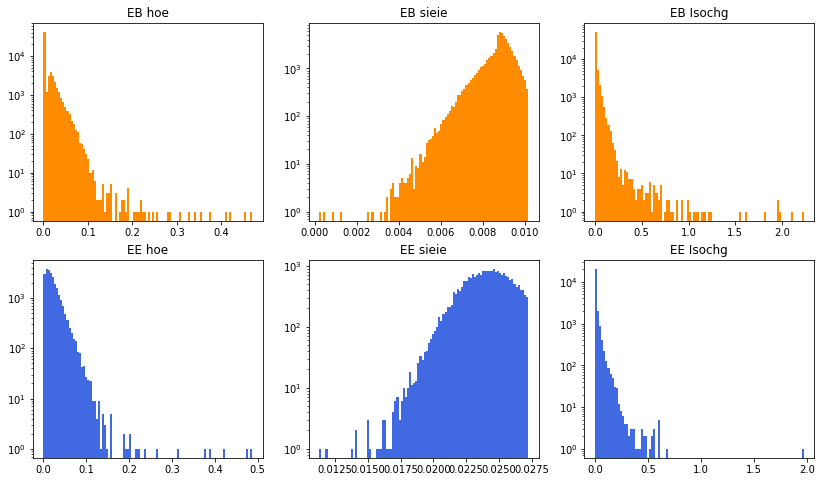

In [14]:
vid_hist(hoe_arr_EB, sieie_arr_EB, Isochg_arr_EB,hoe_arr_EE, sieie_arr_EE, Isochg_arr_EE) # Med without Isochg

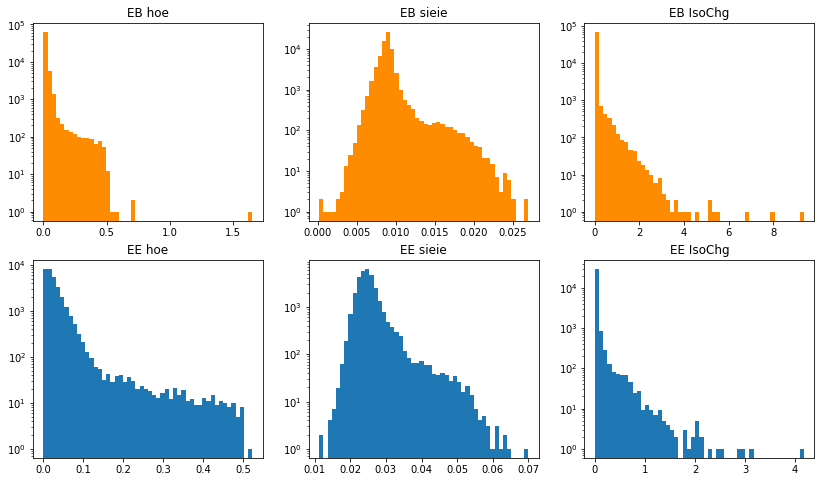

In [68]:
make_hist(EE_Photon,EB_Photon) # without selection